# Project Akhir: Image Classification Model Deployment
---
---
* Nama: Benjamin Nikholas
* Email: benjisturi@gmail.com
* Nomor Telp : [6287892677303](wa.me/6287892677303)

Kriteria Parameter:
1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
2. Dataset tidak pernah digunakan pada submission kelas machine learning sebelumnya.
3. Dataset dibagi menjadi 80% train set dan 20% test set.
4. Model harus menggunakan model sequential.
5. Model harus menggunakan **Conv2D Maxpooling Layer**.
6. Akurasi pada training dan validation set minimal sebesar 80%.
7. Menggunakan Callback.
8. Membuat plot terhadap akurasi dan loss model.
9. Menulis kode untuk menyimpan model ke dalam format **TF-Lite**.

---

Kriteria target nilai sempurna **(bintang 5)**:
1. dataset yang digunakan memiliki minimal 10000 gambar
2. akurasi pada training set dan validation set minimal 92%
3. memiliki minimal 3 kelas

### Library and Packages

In [1]:
import os
import zipfile
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
import random
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [2]:
def SetSeed(seed:int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    check_random_state(seed)

### Data Download
---
Data yang digunakan merupakan data image nasi yang didownload dari [kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)


Link lengkap ada dibawah ini:

`https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset`

---

In [3]:
# Install API Kaggle in Google Colaboratory
!pip install kaggle

In [4]:
# Upload API JSON File Credential

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
# Move JSON File and giving access

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download Dataset

!kaggle datasets download -d muratkokludataset/rice-image-dataset

 93% 203M/219M [00:01<00:00, 234MB/s]
100% 219M/219M [00:01<00:00, 202MB/s]


In [7]:
# Unzip zip file

with zipfile.ZipFile('/content/rice-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [8]:
# Delete txt file

file_path = os.path.join('/content/Rice_Image_Dataset', 'Rice_Citation_Request.txt')

if os.path.exists(file_path):
  os.remove(file_path)
  print('200 OK')
else:
  print('404 NOT FOUND')

200 OK


In [9]:
# Check the number of images in each directory

rice_image_dir = np.array(os.listdir('/content/Rice_Image_Dataset'))

for dir in rice_image_dir:
  length_dir = len(os.listdir(f'/content/Rice_Image_Dataset/{dir}'))
  print(f'Total {dir} images: {length_dir}')

Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000
Total Arborio images: 15000


In [10]:
# Directory benchmark

rice_image_dir = '/content/Rice_Image_Dataset'
output_dir = '/content/Rice_Image_Dataset_Limited'

# Limit the number of images to 3000 per directory
num_images_per_directory = 3000

# Create a new directory for the limited dataset
os.makedirs(output_dir, exist_ok=True)

for dir_name in os.listdir(rice_image_dir):
    current_dir = os.path.join(rice_image_dir, dir_name)
    output_subdir = os.path.join(output_dir, dir_name)
    os.makedirs(output_subdir, exist_ok = True)

    all_images = os.listdir(current_dir)
    selected_images = all_images[:num_images_per_directory]

    # Copy selected images to the new directory
    for image_name in selected_images:
        source_path = os.path.join(current_dir, image_name)
        destination_path = os.path.join(output_subdir, image_name)
        shutil.copyfile(source_path, destination_path)

In [11]:
# Verify the total number of images

total_images = sum([len(files) for _, _, files in os.walk(output_dir)])
print(f'Total images: {total_images}')

# Create data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Set image shape
image_shape = (20, 20)

train_generator = datagen.flow_from_directory(
    output_dir,
    target_size = image_shape,
    class_mode = 'categorical',
    subset = 'training'
)

val_generator = datagen.flow_from_directory(
    output_dir,
    target_size = image_shape,
    class_mode = 'categorical',
    subset = 'validation'
)

Total images: 15000
Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.


### Exploratory Data Analysis

### CNN Model

In [12]:
# CNN Model

SetSeed(2024)

# Set input image shape on first layer
input_image = (image_shape, 3)
input_image = (*input_image[0], input_image[1])

model = Sequential([

    # Add Convolutional Layer
    layers.Conv2D(64,
                  (3,3),
                  activation = 'relu',
                  input_shape = input_image),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32,
                  (3,3),
                  activation = 'relu'),
    layers.MaxPooling2D(2, 2),

    layers.Dropout(0.5),

    layers.Flatten(),

    # Add Fully Connected Layer
    layers.Dense(128,
                 activation = 'relu'),
    layers.Dense(64,
                 activation = 'relu'),
    layers.Dense(5,
                 activation = 'softmax')
])

In [13]:
# Implement Callbacks

SetSeed(2024)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor = 'accuracy',
    min_delta = 0.001,
    verbose = 2,
    patience = 2,
    restore_best_weights = True,
    mode = 'max'
)

In [14]:
# Model Compiling

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

In [15]:
# Model Fitting

model_fit = model.fit(train_generator,
                      validation_data = val_generator,
                      epochs = 50,
                      verbose = 2,
                      batch_size = 64,
                      callbacks = EarlyStop)

Epoch 1/50
375/375 - 12s - loss: 0.5331 - accuracy: 0.7804 - val_loss: 0.1905 - val_accuracy: 0.9290 - 12s/epoch - 31ms/step
Epoch 2/50
375/375 - 9s - loss: 0.2673 - accuracy: 0.8947 - val_loss: 0.1272 - val_accuracy: 0.9543 - 9s/epoch - 25ms/step
Epoch 3/50
375/375 - 10s - loss: 0.2325 - accuracy: 0.9118 - val_loss: 0.1345 - val_accuracy: 0.9493 - 10s/epoch - 28ms/step
Epoch 4/50
375/375 - 10s - loss: 0.2074 - accuracy: 0.9243 - val_loss: 0.1018 - val_accuracy: 0.9690 - 10s/epoch - 27ms/step
Epoch 5/50
375/375 - 10s - loss: 0.1889 - accuracy: 0.9321 - val_loss: 0.0973 - val_accuracy: 0.9677 - 10s/epoch - 26ms/step
Epoch 6/50
375/375 - 9s - loss: 0.1695 - accuracy: 0.9372 - val_loss: 0.0890 - val_accuracy: 0.9657 - 9s/epoch - 23ms/step
Epoch 7/50
375/375 - 10s - loss: 0.1600 - accuracy: 0.9395 - val_loss: 0.0868 - val_accuracy: 0.9633 - 10s/epoch - 27ms/step
Epoch 8/50
375/375 - 10s - loss: 0.1451 - accuracy: 0.9477 - val_loss: 0.0973 - val_accuracy: 0.9610 - 10s/epoch - 28ms/step
Epoc

In [18]:
# Check model fitting history data

df_history = pd.DataFrame(model_fit.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.533059,0.780417,0.190487,0.929000
1,0.267307,0.894667,0.127243,0.954333
2,0.232479,0.911750,0.134544,0.949333
3,0.207401,0.924333,0.101802,0.969000
4,0.188853,0.932083,0.097276,0.967667


In [20]:
# Check accuracy on train and validation data

min_accuracy = 0.92

print(f'train accuracy > 92% is {df_history.accuracy.max() > min_accuracy}')
print(f'validation accuracy > 92% is {df_history.val_accuracy.max() >= min_accuracy}')

train accuracy > 92% is True
validation accuracy > 92% is True


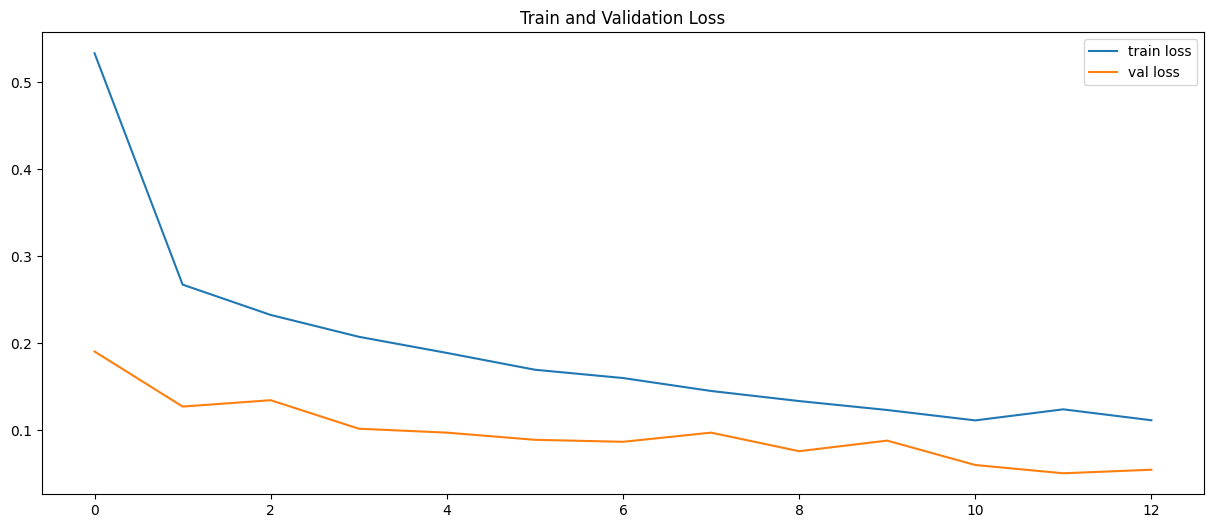

In [21]:
# Plot Loss on Training and Validation data

plt.plot(df_history.loss, label = 'train loss')
plt.plot(df_history.val_loss, label = 'val loss')
plt.title('Train and Validation Loss')
plt.legend()

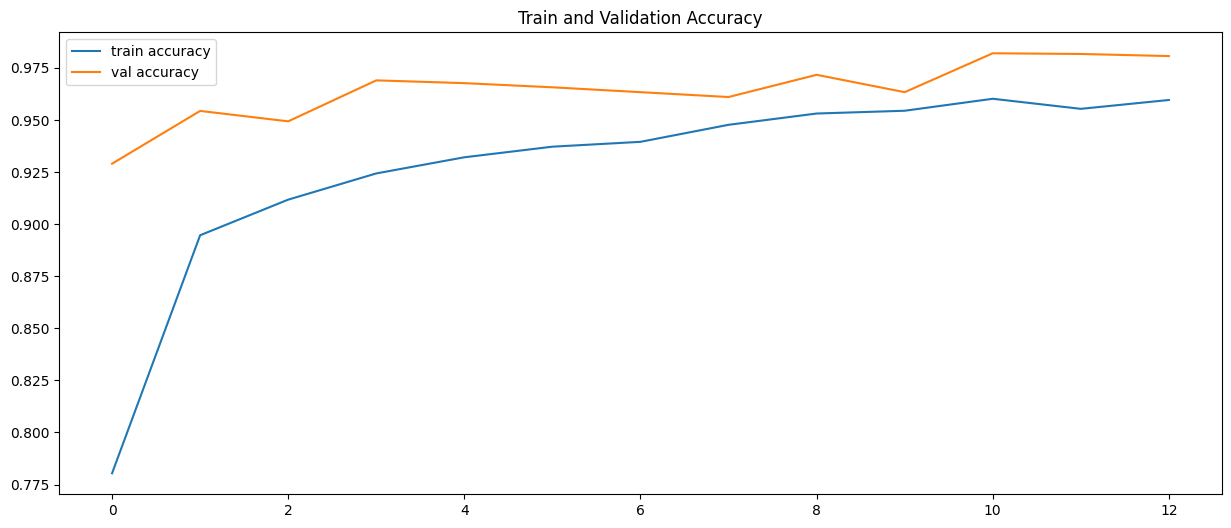

In [22]:
# Plot Accuracy on Train and Validation data

plt.plot(df_history.accuracy, label = 'train accuracy')
plt.plot(df_history.val_accuracy, label = 'val accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

### Model Deployment

In [ ]:
# Save model

save_path = 'mymodel/'
tf.saved_model.save(model, save_path)

In [ ]:
# Convert model format in SavedModel to TensorFlow Lite

converter = tf.lite.TFLiteConverter.from_saved_model('/content/mymodel')
tflite_model = converter.convert()

with tf.io.gfile.GFile('CNNModel_Benjamin.tflite', 'wb') as f:
    f.write(tflite_model)